# Interpoate 3 mic to Grids

In [1]:
import sarracen
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy
from scipy import optimize

In [2]:
sns.set(font_scale=2)
sns.set_style("ticks")

# 2-fluid

In [ ]:
#I think 180 is the last dumpfile we could have before submitting the paper. May9
rho_g_2f = pd.DataFrame()
rho_d_2f = pd.DataFrame()
dtg_2f = pd.DataFrame()
files = [('2fluid/2f3mic256_00{:03d}'.format(i)) for i in range(40, 241, 20)]

for file in files:
    sdf_g, sdf_d = sarracen.read_phantom(file, separate_types='all')
    sdf_g.calc_density()
    sdf_d.calc_density()
    
    grid_g = sdf_g.sph_interpolate('rho', x_pixels=512, y_pixels=512, z_pixels=512, backend='cpu').flatten()
    grid_d = sdf_d.sph_interpolate('rho', x_pixels=512, y_pixels=512, z_pixels=512, backend='cpu').flatten()
    
    rho_g_2f[file], bins = np.histogram(np.log(grid_g), bins=120, range=(-30, 10))
    rho_g_2f['bins'] = bins[:120]
    rho_d_2f[file], bins = np.histogram(np.log(grid_d), bins=120, range=(-30, 10))
    rho_d_2f['bins'] = bins[:120]
    dtg_2f[file], bins = np.histogram(np.log10((grid_d + 1e-40) / (grid_g + 1e-40)), bins=120, range=(-12, 1))
    dtg_2f['bins'] = bins[:120]
    
    
    
def reshape_normalize_data(df):
    columns = df.columns.to_list()
    columns.remove('bins')

    for column in columns:
        df[column] = df[column] / df[column].sum()

    df_melt = df.melt(id_vars=['bins'], value_vars=columns)
    
    return df_melt


rho_g_2f_melt = reshape_normalize_data(rho_g_2f)
rho_d_2f_melt = reshape_normalize_data(rho_d_2f)

dtg_2f_melt = reshape_normalize_data(dtg_2f)

In [ ]:
rho_g_2f_melt[['bins', 'value']].to_csv('csv_files/rho_g_2f_melt_b')
rho_d_2f_melt[['bins', 'value']].to_csv('csv_files/rho_d_2f_melt_b')
dtg_2f_melt[['bins', 'value']].to_csv('csv_files/dtg_2f_grid_melt_b')

rho_g_2f.to_csv('csv_files/rho_g_2f_b')
rho_d_2f.to_csv('csv_files/rho_d_2f_b')
dtg_2f.to_csv('csv_files/dtg_2f_b')

# 1-fluid

In [ ]:
rho_d_1f = pd.DataFrame()
rho_g_1f = pd.DataFrame()
dtg_1f_part = pd.DataFrame()
dtg_1f_grid = pd.DataFrame()

files = [('limited/3mic256l_00{:03d}'.format(i)) for i in range(40, 241, 20)]

for file in files:
    sdf = sarracen.read_phantom(file)
    sdf.calc_density()
    sdf['rho_g'] = sdf['rho'] * (1.0 - sdf['dustfrac'])
    sdf['rho_d'] = sdf['rho'] * sdf['dustfrac']
    sdf['dtg'] = sdf['dustfrac'] / (1.0 - sdf['dustfrac']) 
    
    grid_g = sdf.sph_interpolate('rho_g', x_pixels=512, y_pixels=512, z_pixels=512, backend='cpu').flatten()
    grid_d = sdf.sph_interpolate('rho_d', x_pixels=512, y_pixels=512, z_pixels=512, backend='cpu').flatten()
    grid_dtg = sdf.sph_interpolate('dtg', x_pixels=512, y_pixels=512, z_pixels=512, backend='cpu').flatten()

    rho_g_1f[file], bins = np.histogram(np.log(grid_g + 1.0e-40), bins=120, range=(-30, 10))
    rho_g_1f['bins'] = bins[:120]
    rho_d_1f[file], bins = np.histogram(np.log(grid_d + 1.0e-40), bins=120, range=(-30, 10))
    rho_d_1f['bins'] = bins[:120]
    dtg_1f_part[file], bins = np.histogram(np.log10(grid_dtg), bins=120, range=(-12, 1)) 
    dtg_1f_part['bins'] = bins[:120]
    dtg_1f_grid[file], bins = np.histogram(np.log10((grid_d + 1e-40) / (grid_g + 1e-40)), bins=120, range=(-12, 1))
    dtg_1f_grid['bins'] = bins[:120]

    

def reshape_normalize_data(df):
    columns = df.columns.to_list()
    columns.remove('bins')

    for column in columns:
        df[column] = df[column] / df[column].sum()

    df_melt = df.melt(id_vars=['bins'], value_vars=columns)
    
    return df_melt

rho_g_1f_melt = reshape_normalize_data(rho_g_1f)
rho_d_1f_melt = reshape_normalize_data(rho_d_1f)

dtg_1f_part_melt = reshape_normalize_data(dtg_1f_part)
dtg_1f_grid_melt = reshape_normalize_data(dtg_1f_grid)

In [ ]:
rho_g_1f_melt[['bins', 'value']].to_csv('csv_files/rho_g_1f_melt_b')
rho_d_1f_melt[['bins', 'value']].to_csv('csv_files/rho_d_1f_melt_b')
dtg_1f_grid_melt[['bins', 'value']].to_csv('csv_files/dtg_1f_grid_melt_b')
dtg_1f_part_melt[['bins', 'value']].to_csv('csv_files/dtg_1f_part_melt_b')


rho_g_1f.to_csv('csv_files/rho_g_1f_b')
rho_d_1f.to_csv('csv_files/rho_d_1f_b')
dtg_1f_grid.to_csv('csv_files/dtg_1f_grid_b')
dtg_1f_part.to_csv('csv_files/dtg_1f_part_b')

# 1-fluid Non-imited

In [ ]:
rho_d_nl = pd.DataFrame()
rho_g_nl = pd.DataFrame()
dtg_nl_part = pd.DataFrame()
dtg_nl_grid = pd.DataFrame()

files = [('nonlimited/3mic256nl_00{:03d}'.format(i)) for i in range(40, 241, 20)]

for file in files:
    sdf = sarracen.read_phantom(file)
    sdf.calc_density()
    sdf['rho_g'] = sdf['rho'] * (1.0 - sdf['dustfrac'])
    sdf['rho_d'] = sdf['rho'] * sdf['dustfrac']
    sdf['dtg'] = sdf['dustfrac'] / (1.0 - sdf['dustfrac']) 
    
    grid_g = sdf.sph_interpolate('rho_g', x_pixels=512, y_pixels=512, z_pixels=512, backend='cpu').flatten()
    grid_d = sdf.sph_interpolate('rho_d', x_pixels=512, y_pixels=512, z_pixels=512, backend='cpu').flatten()
    grid_dtg = sdf.sph_interpolate('dtg', x_pixels=512, y_pixels=512, z_pixels=512, backend='cpu').flatten()

    rho_g_nl[file], bins = np.histogram(np.log(grid_g + 1.0e-40), bins=120, range=(-30, 10))
    rho_g_nl['bins'] = bins[:120]
    rho_d_nl[file], bins = np.histogram(np.log(grid_d + 1.0e-40), bins=120, range=(-30, 10))
    rho_d_nl['bins'] = bins[:120]
    dtg_nl_part[file], bins = np.histogram(np.log10(grid_dtg), bins=120, range=(-12, 1)) 
    dtg_nl_part['bins'] = bins[:120]
    dtg_nl_grid[file], bins = np.histogram(np.log10((grid_d + 1e-40) / (grid_g + 1e-40)), bins=120, range=(-12, 1))
    dtg_nl_grid['bins'] = bins[:120]

    

def reshape_normalize_data(df):
    columns = df.columns.to_list()
    columns.remove('bins')

    for column in columns:
        df[column] = df[column] / df[column].sum()

    df_melt = df.melt(id_vars=['bins'], value_vars=columns)
    
    return df_melt

rho_g_nl_melt = reshape_normalize_data(rho_g_nl)
rho_d_nl_melt = reshape_normalize_data(rho_d_nl)

# dtg_nl_part_melt = reshape_normalize_data(dtg_nl_part)
dtg_nl_melt = reshape_normalize_data(dtg_nl_grid)

In [ ]:
rho_g_nl_melt[['bins', 'value']].to_csv('csv_files/rho_g_nl_melt_b')
rho_d_nl_melt[['bins', 'value']].to_csv('csv_files/rho_d_nl_melt_b')
dtg_nl_melt[['bins', 'value']].to_csv('csv_files/dtg_nl_melt_b')

rho_g_nl.to_csv('csv_files/rho_g_nl_b')
rho_d_nl.to_csv('csv_files/rho_d_nl_b')
dtg_nl_grid.to_csv('csv_files/dtg_nl_b')

# Read csv files

In [3]:
rho_g_2f_melt = pd.read_csv('csv_files/rho_g_2f_melt_b', index_col=0)
rho_d_2f_melt = pd.read_csv('csv_files/rho_d_2f_melt_b', index_col=0)
dtg_2f_melt = pd.read_csv('csv_files/dtg_2f_grid_melt_b', index_col=0)

rho_g_2f = pd.read_csv('csv_files/rho_g_2f_b', index_col=0)
rho_d_2f = pd.read_csv('csv_files/rho_d_2f_b', index_col=0)
dtg_2f = pd.read_csv('csv_files/dtg_2f_b', index_col=0)

In [4]:
rho_g_1f_melt = pd.read_csv('csv_files/rho_g_1f_melt_b', index_col=0)
rho_d_1f_melt = pd.read_csv('csv_files/rho_d_1f_melt_b', index_col=0)
dtg_1f_grid_melt = pd.read_csv('csv_files/dtg_1f_grid_melt_b', index_col=0)

rho_g_1f = pd.read_csv('csv_files/rho_g_1f_b', index_col=0)
rho_d_1f = pd.read_csv('csv_files/rho_d_1f_b', index_col=0)
dtg_1f_grid = pd.read_csv('csv_files/dtg_1f_grid_b', index_col=0)

In [5]:
rho_g_nl_melt = pd.read_csv('csv_files/rho_g_nl_melt_b', index_col=0)
rho_d_nl_melt = pd.read_csv('csv_files/rho_d_nl_melt_b', index_col=0)
dtg_nl_melt = pd.read_csv('csv_files/dtg_nl_melt_b', index_col=0)

rho_g_nl = pd.read_csv('csv_files/rho_g_nl_b', index_col=0)
rho_d_nl = pd.read_csv('csv_files/rho_d_nl_b', index_col=0)
dtg_nl = pd.read_csv('csv_files/dtg_nl_b', index_col=0)

# Gas, Dust and Dust-to-Gas Ratio PDFs

In [6]:
rho_g_1f_melt['Approach']='1-fluid'
rho_g_2f_melt['Approach']='2-fluid'

rho_d_1f_melt['Approach']='1-fluid'
rho_d_2f_melt['Approach']='2-fluid'

dtg_1f_grid_melt['Approach']='1-fluid'

dtg_2f_melt['Approach']='2-fluid'

In [7]:
rho_g_melt = pd.concat([rho_g_1f_melt, rho_g_2f_melt], axis=0)

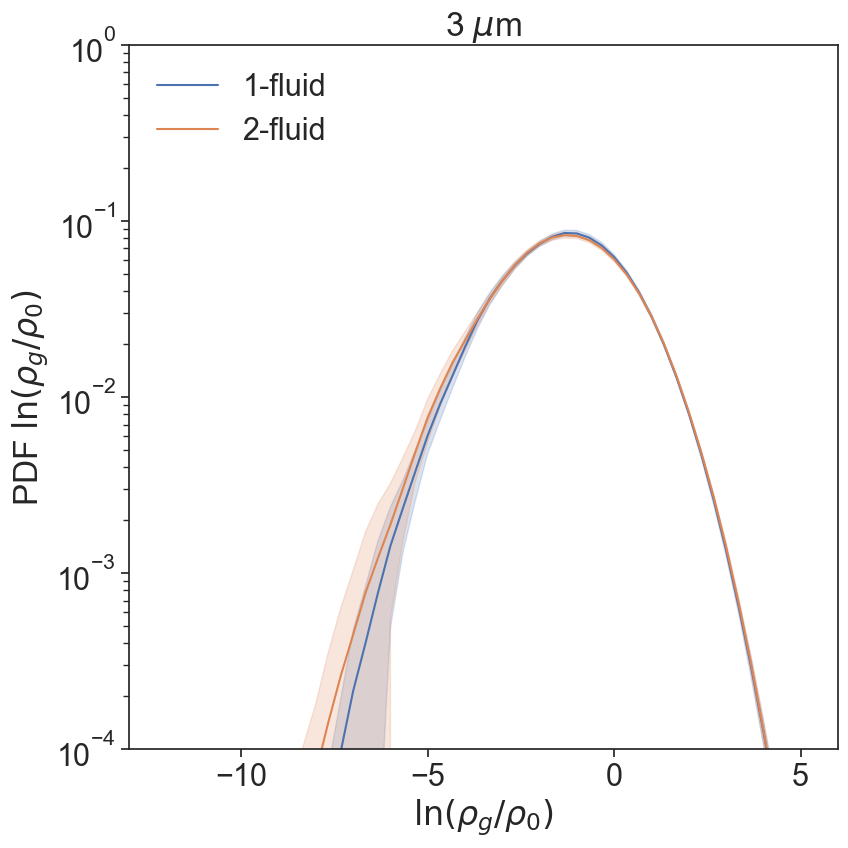

In [8]:
fig, ax = plt.subplots(figsize=(9,9))
ax = sns.lineplot(data=rho_g_melt, x='bins', y='value', ax=ax, errorbar='sd', hue='Approach')
ax.set_yscale('log')
ax.set_ylim((1e-4, 1))
ax.set_xlim((-13,6))
ax.set(xlabel=r'$\ln(\rho_{g}/\rho_0)$',
       ylabel=r'PDF $\ln(\rho_g/\rho_0)$',
       title=r'3 $\mu$m')
sns.move_legend(ax, "upper left", frameon=False)
ax.legend_.set_title(None)
fig.tight_layout()
fig.savefig('gasPDF3mic_l2f.pdf')

In [9]:
rho_d_melt = pd.concat([rho_d_1f_melt, rho_d_2f_melt], axis=0)

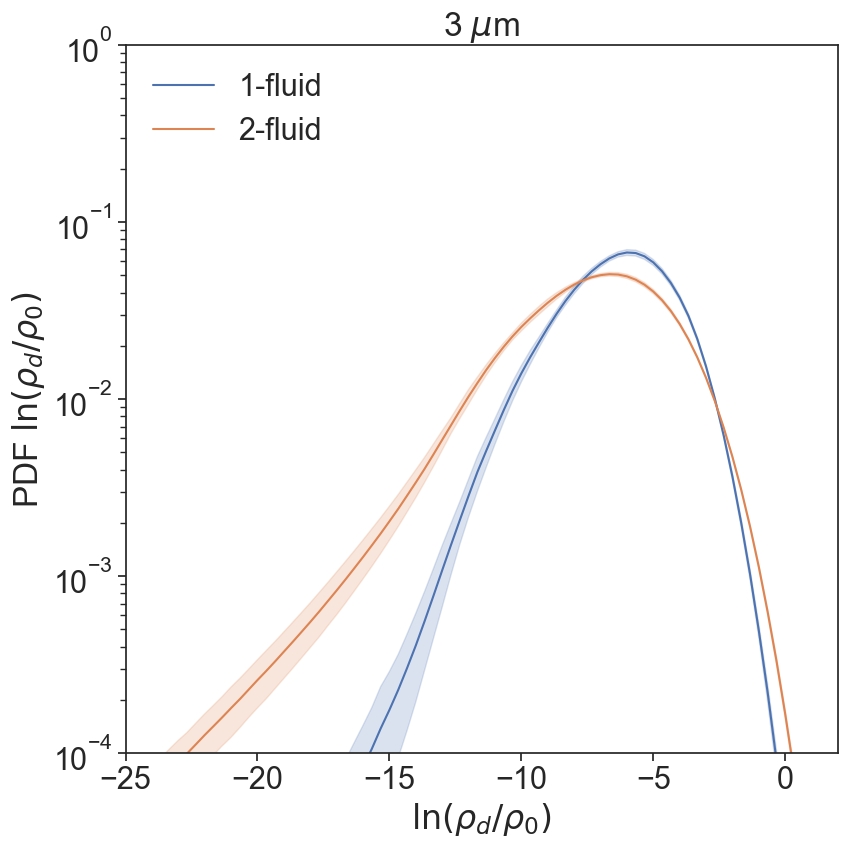

In [10]:
fig, ax = plt.subplots(figsize=(9,9))
ax = sns.lineplot(data=rho_d_melt, x='bins', y='value', ax=ax, errorbar='sd', hue='Approach')
ax.set_yscale('log')
ax.set_ylim((1e-4, 1))
ax.set_xlim((-25,2))
ax.set(xlabel=r'$\ln(\rho_{d}/\rho_0)$',
       ylabel=r'PDF $\ln(\rho_d/\rho_0)$',
       title=r'3 $\mu$m')
sns.move_legend(ax, "upper left", frameon=False)
ax.legend_.set_title(None)
fig.tight_layout()
fig.savefig('dustPDF3mic_l2f.pdf')

In [11]:
dtg_melt = pd.concat([ dtg_1f_grid_melt, dtg_2f_melt], axis=0)

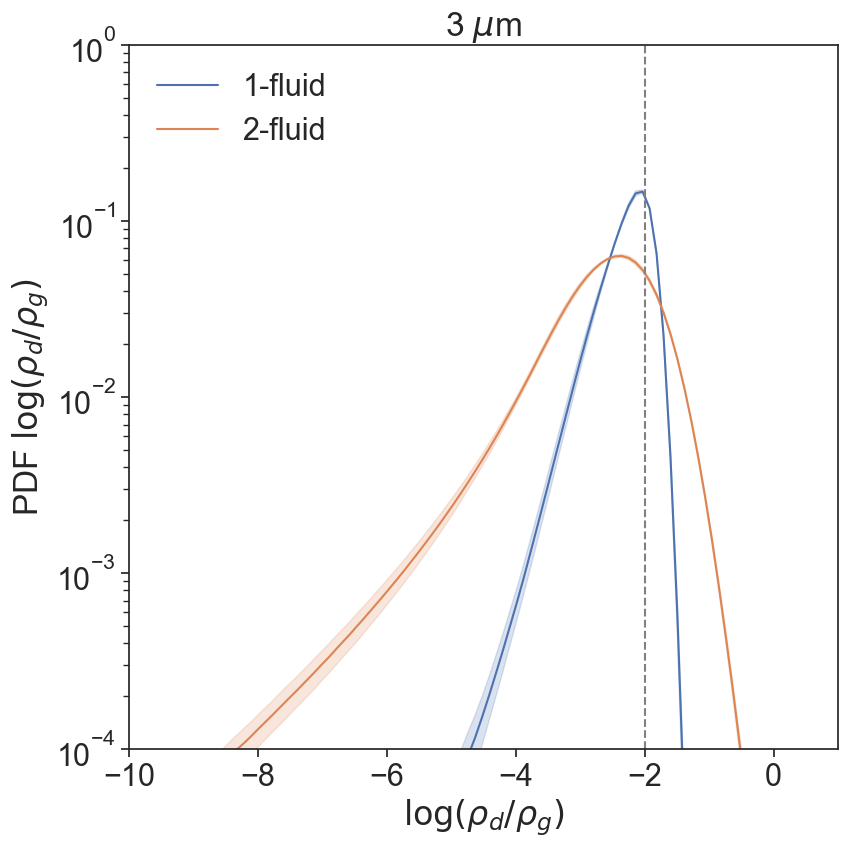

In [12]:
fig, ax = plt.subplots(figsize=(9,9))
ax = sns.lineplot(data=dtg_melt , x='bins', y='value', ax=ax, errorbar='sd', hue='Approach')
ax.vlines(-2, 1e-4, 1, color='grey', linestyle='--')
# ax.grid()
ax.set_yscale('log')
ax.set_xlim((-10, 1))
ax.set_ylim((1e-4, 1))
ax.set(xlabel=r'$\log(\rho_d/\rho_g)$',
       ylabel=r'PDF $\log(\rho_d/\rho_g)$',
       title=r'3 $\mu$m')
sns.move_legend(ax, "upper left", frameon=False)
ax.legend_.set_title(None)
fig.tight_layout()
fig.savefig('dtg3mic_l2f.pdf')

### Average of  gas and dust PDFs

In [13]:
#Finding average of PDFs
def mean(df):
    df_drop = df.copy()
    mean = pd.DataFrame()
    mean['value'] = df_drop.drop('bins', axis = 1).mean(axis = 1)
    mean['bins'] = rho_g_1f['bins']
    return mean

rho_mean_g_1f = mean(rho_g_1f)
rho_mean_g_2f = mean(rho_g_2f)

rho_mean_d_1f = mean(rho_d_1f)
rho_mean_d_2f = mean(rho_d_2f)

### Fitting normal distributions to the gas PDFs of 1-fluid and 2-fluid

In [14]:
# Fit a Gaussian function 
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / np.sqrt(2) / stddev)**2)/(np.sqrt(2*np.pi))
    return y

In [15]:
# Gas PDF in 1-fluid method

x = rho_mean_g_1f['bins']
y = rho_mean_g_1f['value']

# Fit the Gaussian function to the data
popt_1f_g, cov = optimize.curve_fit(gaussian, x, y)

# Extract the fitted parameters
amplitude_1f_g, mean_1f_g, stddev_1f_g = popt_1f_g

print('amplitude, mean, stddev:', amplitude_1f_g, mean_1f_g, stddev_1f_g)
print('variences for amplitude, mean, stddev:', np.sqrt(np.diag(cov)))

amplitude, mean, stddev: 0.21379374108350882 -1.2637991054523998 1.557970850134347
variences for amplitude, mean, stddev: [0.00060032 0.00505143 0.00505143]


In [16]:
# Gas PDF in 2-fluid method

x = rho_mean_g_2f['bins']
y = rho_mean_g_2f['value']

# Fit the Gaussian function to the data
popt_2f_g, cov = optimize.curve_fit(gaussian, x, y)

# Extract the fitted parameters
amplitude_2f_g, mean_2f_g, stddev_2f_g = popt_2f_g

print('amplitude, mean, stddev:', amplitude_2f_g, mean_2f_g, stddev_2f_g)
print('variences for amplitude, mean, stddev:', np.sqrt(np.diag(cov)))

amplitude, mean, stddev: 0.20851176320587397 -1.2971647948553475 1.5929772838042304
variences for amplitude, mean, stddev: [0.00062243 0.00549086 0.00549086]


### Fitting normal distributions to dust PDFs of 1-fluid and 2-fluid

In [17]:
# Dust PDF in 1-fluid method

x = rho_mean_d_1f['bins']
y = rho_mean_d_1f['value']

# Initial guesses for amplitude, mean, and stddev
initial_guesses = [max(y), np.mean(x), np.std(x)]

# Bounds for amplitude (positive), mean (any value), and stddev (positive)
bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])

# Fit the Gaussian function to the data
popt_1f_d, cov = optimize.curve_fit(gaussian, x, y, p0=initial_guesses, bounds=bounds)

# Extract the fitted parameters
amplitude_1f_d, mean_1f_d, stddev_1f_d = popt_1f_d

print('amplitude, mean, stddev:', amplitude_1f_d, mean_1f_d, stddev_1f_d)
print('variences for amplitude, mean, stddev:', np.sqrt(np.diag(cov)))

amplitude, mean, stddev: 0.16692561847530193 -6.170429604627577 1.9783837453784112
variences for amplitude, mean, stddev: [0.00138767 0.01899081 0.01899081]


In [18]:
# Dust PDF in 2-fluid method

x = rho_mean_d_2f['bins']
y = rho_mean_d_2f['value']

# Initial guesses for amplitude, mean, and stddev
initial_guesses = [max(y), np.mean(x), np.std(x)]

# Bounds for amplitude (positive), mean (any value), and stddev (positive)
bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])

# Fit the Gaussian function to the data
popt_2f_d, cov = optimize.curve_fit(gaussian, x, y, p0=initial_guesses, bounds=bounds)

# Extract the fitted parameters
amplitude_2f_d, mean_2f_d, stddev_2f_d = popt_2f_d

print('amplitude, mean, stddev:', amplitude_2f_d, mean_2f_d, stddev_2f_d)
print('variences for amplitude, mean, stddev:', np.sqrt(np.diag(cov)))

amplitude, mean, stddev: 0.1265915413371726 -6.977642568559292 2.5923301298149717
variences for amplitude, mean, stddev: [0.00114204 0.0270046  0.0270046 ]


# Dust-to-gas PDFs for limited and non-limited 1-fluid

In [19]:
dtg_1f_grid_melt['method']= 'Limited'
dtg_nl_melt['method']= 'Non-limited'
dtg_melt_l_nl = pd.concat([ dtg_1f_grid_melt, dtg_nl_melt], axis=0)

In [20]:
dtg_melt_l_nl = pd.concat([dtg_1f_grid_melt, dtg_nl_melt], axis=0)

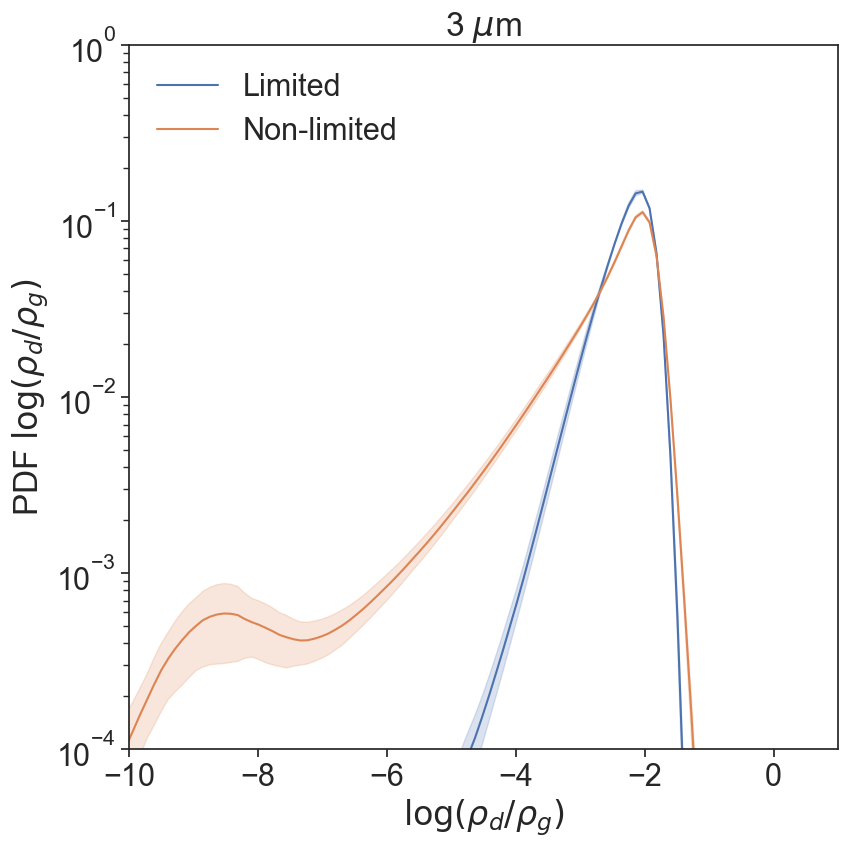

In [23]:
fig, ax = plt.subplots(figsize=(9,9))
ax = sns.lineplot(data=dtg_melt_l_nl , x='bins', y='value', ax=ax, errorbar='sd', hue='method')
ax.set_yscale('log')
ax.set_xlim((-10, 1))
ax.set_ylim((1e-4, 1))
ax.set(xlabel=r'$\log(\rho_d/\rho_g)$',
       ylabel=r'PDF $\log(\rho_d/\rho_g)$',
       title=r'3 $\mu$m')
sns.move_legend(ax, "upper left", frameon=False)
ax.legend_.set_title(None)
fig.tight_layout()
# fig.savefig('dtg3mic_l-vs-nl.pdf')

# Max of dust-to-gas ratio in the plots

In [24]:
#Finding average of dust-to-gas pdfs
def mean_dtg(df):
    df_drop = df.copy()
    mean = pd.DataFrame()
    mean['value'] = df_drop.drop('bins', axis = 1).mean(axis = 1)
    mean['bins'] = dtg_1f_grid['bins']
    return mean

dtg_mean_1f = mean_dtg(dtg_1f_grid)
dtg_mean_2f = mean_dtg(dtg_2f)

In [25]:
dtg_mean_1f.iloc[90:100]

,value,bins
90,0.122179,-2.250000
91,0.143649,-2.141667
92,0.147131,-2.033333
93,0.118292,-1.925000
94,0.065581,-1.816667
95,0.022521,-1.708333
96,0.004570,-1.600000
97,0.000558,-1.491667
98,0.000042,-1.383333
99,0.000002,-1.275000


In [26]:
print('Max of dtg in 1-fluid:', 10**-1.491667)

Max of dtg in 1-fluid: 0.03223539527793492


In [27]:
dtg_mean_2f.iloc[100:110]

,value,bins
100,0.004511,-1.166667
101,0.002659,-1.058333
102,0.001496,-0.950000
103,0.000806,-0.841667
104,0.000416,-0.733333
105,0.000209,-0.625000
106,0.000100,-0.516667
107,0.000047,-0.408333
108,0.000021,-0.300000
109,0.000009,-0.191667


In [28]:
print('Max of dtg in 2-fluid:', 10**-0.516667)

Max of dtg in 2-fluid: 0.3043217551351036
